In [1]:
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.models import load_model
from keras import backend as K
from keras.layers import Activation
from keras.utils import get_custom_objects
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, MaxPooling1D, Embedding, Conv2D, MaxPooling2D
from keras import callbacks

In [ ]:
!pip install rasterio

In [2]:
from PIL import Image
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import os
from sklearn.metrics import matthews_corrcoef

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


File Path: /content/drive/MyDrive/train/00/2021-06-06.tiff
Driver: GTiff
Width: 215
Height: 222
Count (Bands): 5
CRS: EPSG:4326
Transform: | 10.00, 0.00, 71.47|
| 0.00,-10.00, 56.30|
| 0.00, 0.00, 1.00|
Bounding Box: BoundingBox(left=71.474895, bottom=-2163.700927, right=2221.474895, top=56.299073)
Datum: ('float32', 'float32', 'float32', 'float32', 'float32')

Band 1:
  Data Type: float32
  Min Value: 4.0
  Max Value: 23.0
  Mean Value: 12.358684539794922
  Standard Deviation: 3.08229660987854

Band 2:
  Data Type: float32
  Min Value: 5.0
  Max Value: 30.0
  Mean Value: 15.506264686584473
  Standard Deviation: 4.18515682220459

Band 3:
  Data Type: float32
  Min Value: 4.0
  Max Value: 41.0
  Mean Value: 18.802011489868164
  Standard Deviation: 6.582454204559326

Band 4:
  Data Type: float32
  Min Value: 4.0
  Max Value: 76.0
  Mean Value: 34.52409362792969
  Standard Deviation: 11.44923210144043

Band 5:
  Data Type: float32
  Min Value: 0.0
  Max Value: 1.0
  Mean Value: 0.13266289

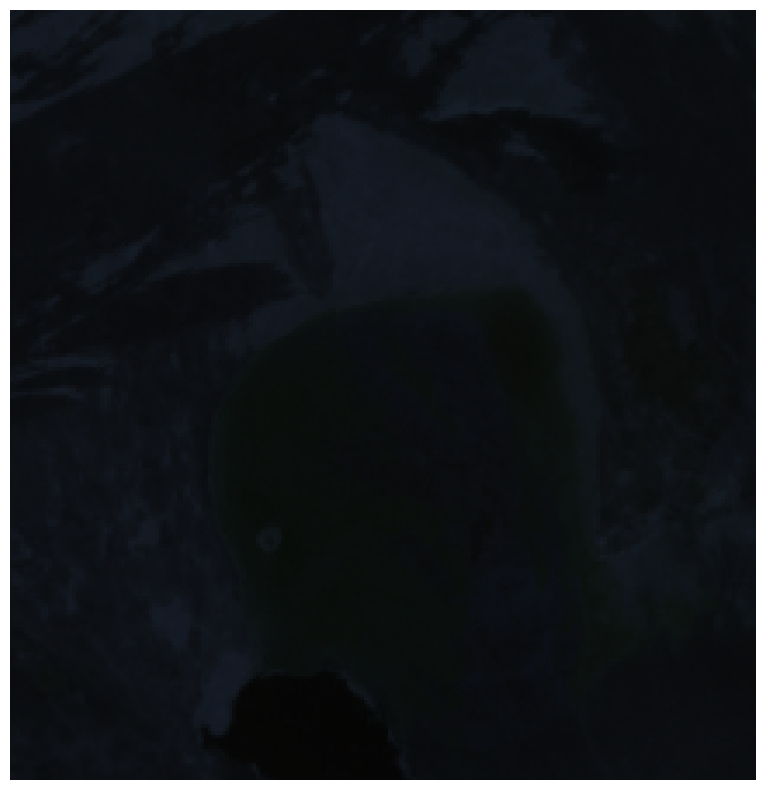

In [22]:
file_path = r'/content/drive/MyDrive/train/00/2021-06-06.tiff'


# In[4]:


def print_geotiff_info(path):
    try:
        # Открываем файл
        with rasterio.open(path) as src:
            # Основные метаданные
            print(f"File Path: {path}")
            print(f"Driver: {src.driver}")
            print(f"Width: {src.width}")
            print(f"Height: {src.height}")
            print(f"Count (Bands): {src.count}")
            print(f"CRS: {src.crs}")
            print(f"Transform: {src.transform}")
            print(f"Bounding Box: {src.bounds}")
            print(f"Datum: {src.dtypes}")

            # Информация по каждому каналу
            for i in range(1, src.count + 1):
                band = src.read(i)
                print(f"\nBand {i}:")
                print(f"  Data Type: {src.dtypes[i - 1]}")
                print(f"  Min Value: {band.min()}")
                print(f"  Max Value: {band.max()}")
                print(f"  Mean Value: {band.mean()}")
                print(f"  Standard Deviation: {band.std()}")

    except Exception as e:
        print(f'Error: {e}')


# Вывод информации о GeoTIFF
print_geotiff_info(file_path)


# In[5]:

def visualize_rgb_geotiff(file_path, r_band, g_band, b_band, ik_band, mask_band):
    try:
        with rasterio.open(file_path) as src:
            num_bands = src.count
            #print(f"Number of bands: {num_bands}")
            red = src.read(r_band)  # B02 - Blue
            green = src.read(g_band)  # B03 - Green
            blue = src.read(b_band)  # B04 - Red
            ik = src.read(ik_band)
            mask = src.read(mask_band)

            photo1 = np.stack([red, green, blue], axis=-1)  # Отрисовка всего изображения
            photo2 = np.stack([ik], axis=-1) # Отрисовка ИК-слоя изображения
            photo3 = np.stack([mask], axis=-1)  # Отрисовка маски изображения

            photo1 = Image.fromarray(photo1.astype(np.uint8), 'RGB')
            #photo2 = Image.fromarray(photo2.astype(np.uint8))
            #photo3 = Image.fromarray(photo3.astype(np.uint8))

            fig, ax = plt.subplots(figsize=(10, 10))
            ax.imshow(photo1)
            #ax.imshow(photo2)
            #ax.imshow(photo3)
            ax.axis('off')
            plt.show()
    except Exception as e:
        print(f'Ошибка: {e}')


# In[6]:
# Визуализация изображения
visualize_rgb_geotiff(file_path, 1, 2, 3, 4, 5)

In [4]:
folders = os.listdir('/content/drive/MyDrive/train/')
photos = []
infos = []
for i in folders:
  photo, info = sorted(os.listdir('/content/drive/MyDrive/train/' + i + '/'))
  photos.append(photo)
  infos.append(info)

In [5]:
a = np.array([])
b = np.array([])
for i in range(21):
  img = np.array(rasterio.open('/content/drive/MyDrive/train/' + folders[i] + '/' + photos[i]).read()).shape
  lenght, width = img[1:]
  a = np.append(a, lenght)
  b = np.append(b, width)

In [6]:
normal_lenght = int(a.mean() / 1.5)
normal_width = int(b.mean() / 1.5)

In [24]:
X_train = np.array([np.array([])])
y_train = np.array([np.array([])])

for i in range(21):
  file_path = '/content/drive/MyDrive/train/' + folders[i] + '/' + photos[i]
  data_path = '/content/drive/MyDrive/train/' + folders[i] + '/' + infos[i]
  img = rasterio.open(file_path)
  red = img.read(1)
  green = img.read(2)
  blue = img.read(3)
  ik = img.read(4)
  mask = img.read(5)

  photo = Image.fromarray(np.stack([red, green, blue, ik], axis=-1).astype(np.uint8)).resize([normal_width, normal_lenght])

  #rgb_photo = Image.fromarray(np.stack([red, green, blue, ik], axis=-1).astype(np.uint8)).resize([normal_width, normal_lenght])
  #ik_photo = Image.fromarray(np.stack(ik, axis=-1).astype(np.uint8), 'L').resize([normal_width, normal_lenght])
  mask_photo = Image.fromarray(np.stack(mask, axis=-1).astype(np.uint8), 'L').resize([normal_width, normal_lenght])

  #data = pd.read_csv(data_path)
  #data = data.drop('Порывы ветра', axis=1)[:58]
  #data['time'] = np.arange(1, 59)
  #data = (data - data.mean()) / data.std()

  x = np.array(photo).reshape((1, -1)) / 255.0
  y = np.array(mask_photo).reshape((1, -1))

  #x = np.append(x, np.array(data).reshape((1, -1))).reshape((1, -1))

  #x = np.array(data).reshape((1, -1))

  if X_train.shape != (1, 0):
    X_train = np.append(X_train, x, axis=0)
    y_train = np.append(y_train, y, axis=0)

  else:
    X_train = np.append(X_train, x).reshape((1, -1))
    y_train = np.append(y_train, y).reshape((1, -1))

In [ ]:
x2_train = np.array([np.array([])])
y2_train = np.ones(21)
for i in range(21):
  data_path = '/content/drive/MyDrive/train/' + folders[i] + '/' + infos[i]
  data = pd.read_csv(data_path)
  data = data.drop('Порывы ветра', axis=1)[:58]
  data['time'] = np.arange(1, 59)
  #data = (data - data.mean()) / data.std()
  print(data)

  x = np.array(data).reshape((1, -1))

  if x2_train.shape != (1, 0):
    x2_train = np.append(x2_train, x, axis=0)
  else:
    x2_train = np.append(x2_train, x).reshape((1, -1))

In [ ]:
x2_train.shape

(20, 464)

In [ ]:
x2_train.shape

(1, 0)

In [25]:
X_train = X_train.reshape(21, normal_lenght, normal_width, 4)

In [26]:
X_train.shape

(21, 219, 306, 4)

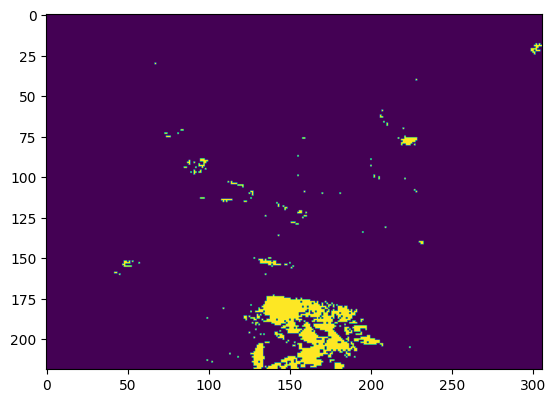

In [ ]:
plt.imshow(y_train[9].reshape(normal_lenght, normal_width))

In [ ]:
def custom_activation(x):
  return np.array(list(map((0, 1)[y >= 0]), x.reshape(-1)))

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

In [ ]:
model = Sequential()

model.add(Dense(464, activation='', input_shape=(464,)))
model.add(Dense(1000, activation='linear'))
model.add(Dense(normal_lenght * normal_width, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='elu', padding='same', input_shape=(normal_lenght, normal_width, 4)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3),  activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=(3, 3), activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(1000, activation='elu'))
model.add(Dense(400, activation='elu'))
model.add(Dense(normal_lenght * normal_width, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 219, 306, 16)        │             592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 219, 306, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 109, 153, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 107, 151, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 53, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 51, 73, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1000)                │      57,601,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 400)                 │         400,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 67014)               │      26,872,614 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,897,806 (323.86 MB)

 Trainable params: 84,897,774 (323.86 MB)

 Non-trainable params: 32 (128.00 B)

In [11]:
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['binary_accuracy'])

In [12]:
model_checkpoint = callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/model_best3{epoch}.keras',
                                             monitor='val_binary_accuracy',
                                             verbose=1,
                                             save_best_only=False,
                                             save_weights_only=False,
                                             mode='auto',
                                             save_freq='epoch')

In [13]:
model.fit(X_train, y_train, epochs=8, verbose=1, batch_size=10, validation_split=0.2, callbacks=model_checkpoint)

Epoch 1/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.5061 - loss: 0.6938
Epoch 1: saving model to /content/drive/MyDrive/model_best31.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 27s/step - binary_accuracy: 0.5082 - loss: 0.6938 - val_binary_accuracy: 0.8552 - val_loss: 0.6513
Epoch 2/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.8951 - loss: 0.4316
Epoch 2: saving model to /content/drive/MyDrive/model_best32.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 33s/step - binary_accuracy: 0.8945 - loss: 0.4454 - val_binary_accuracy: 0.8791 - val_loss: 0.5726
Epoch 3/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9108 - loss: 0.3265
Epoch 3: saving model to /content/drive/MyDrive/model_best33.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 22s/step - binary_accuracy: 0.9094 - loss: 0.3285 - val_binary_accuracy: 0.1835 - val_loss: 0.7410
Epoch 4/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9124 - loss: 0.2958
Epoch 4: saving model to /content/drive/MyDrive/model_best34.keras


In [ ]:
model.get_weights()

In [30]:
pred = best_mod.predict(X_train[3].reshape(1, 219, 306, 4)).reshape(219, 306)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


In [31]:
pred.shape

(219, 306)

In [32]:
for i in range(219):
  for j in range(306):
    if pred[i, j] >= 0.5:
      pred[i, j] = 1
    else:
      pred[i, j] = 0


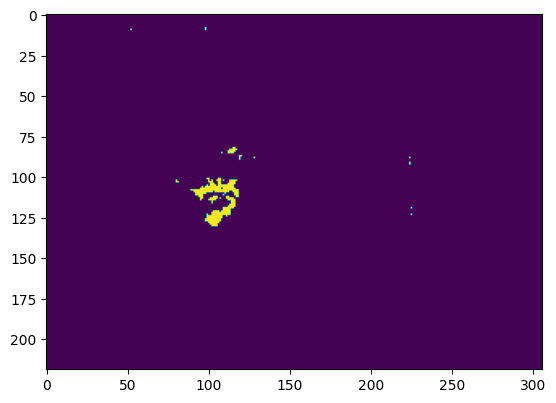

In [ ]:
plt.imshow(y_train[3].reshape(219, 306))

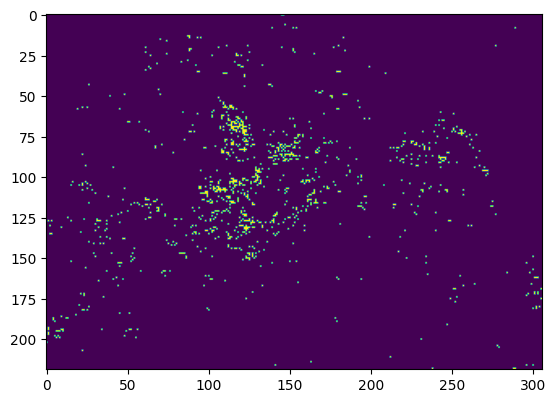

In [ ]:
plt.imshow(pred)

In [29]:
best_mod = load_model('/content/drive/MyDrive/model_best18.keras')

In [ ]:
len(folders)

21

In [28]:
predicts = best_mod.predict(X_train).reshape(21, 219, 306)

for q in range(len(folders)):
  for i in range(normal_lenght):
    for j in range(normal_width):
      if predicts[q, i, j] >= 0.5:
        predicts[q, i, j] = 1
      else:
        predicts[q, i, j] = 0


print(matthews_corrcoef(y_train.reshape(-1), predicts.reshape(-1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
0.06870902169215112


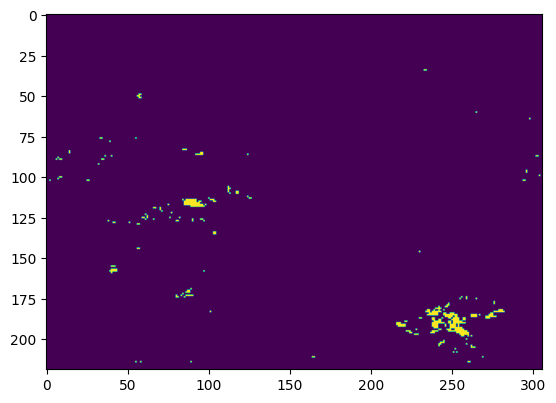

In [ ]:
plt.imshow(y_train.reshape(20, 219, 306)[0])

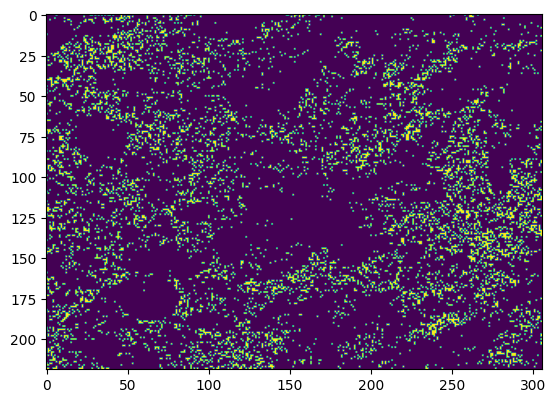

In [ ]:
plt.imshow(predicts[0])

In [ ]:
pd.read_csv('/content/drive/MyDrive/data/data/thermopoints.csv', sep=';')

,dt,type_name,type_id,lon,lat
0,2012-03-13,Природный пожар,4,131.5866,47.8662
1,2012-03-13,Природный пожар,4,131.5885,47.8809
2,2012-03-13,Лесной пожар,3,131.9871,48.4973
3,2012-03-13,Природный пожар,4,131.9031,43.6277
4,2012-03-13,Природный пожар,4,131.5706,47.8581
...,...,...,...,...,...
660249,2021-09-10,Лесной пожар,3,118.5451,64.7475
660250,2021-09-10,Лесной пожар,3,118.3046,64.7629
660251,2021-09-10,Лесной пожар,3,117.9681,65.7394
660252,2021-09-10,Лесной пожар,3,119.0462,64.7541


In [20]:
folders = os.listdir('/content/drive/MyDrive/train/')
photos = []
infos = []
for i in folders:
  photo, info = sorted(os.listdir('/content/drive/MyDrive/train/' + i + '/'))
  photos.append(photo)
  infos.append(info)

X_test = np.array([np.array([])])
y_test = np.array([np.array([])])

for i in range(len(folders)):
  file_path = '/content/drive/MyDrive/test/' + folders[i] + '/' + photos[i]
  data_path = '/content/drive/MyDrive/test/' + folders[i] + '/' + infos[i]
  img = rasterio.open(file_path)
  red = img.read(1)
  green = img.read(2)
  blue = img.read(3)
  ik = img.read(4)
  mask = img.read(5)

  photo = Image.fromarray(np.stack([red, green, blue, ik], axis=-1).astype(np.uint8)).resize([normal_width, normal_lenght])

  #rgb_photo = Image.fromarray(np.stack([red, green, blue, ik], axis=-1).astype(np.uint8)).resize([normal_width, normal_lenght])
  #ik_photo = Image.fromarray(np.stack(ik, axis=-1).astype(np.uint8), 'L').resize([normal_width, normal_lenght])
  mask_photo = Image.fromarray(np.stack(mask, axis=-1).astype(np.uint8), 'L').resize([normal_width, normal_lenght])

  data = pd.read_csv(data_path)
  data = data.drop('Порывы ветра', axis=1)[:58]
  data['time'] = np.arange(1, 59)
  data = (data - data.mean()) / data.std()

  x = np.array(photo).reshape((1, -1)) / 255.0
  y = np.array(mask_photo).reshape((1, -1))

  #x = np.append(x, np.array(data).reshape((1, -1))).reshape((1, -1))

  #x = np.array(data).reshape((1, -1))

  if X_test.shape != (1, 0):
    X_test = np.append(X_test, x, axis=0)
    y_test = np.append(y_test, y, axis=0)

  else:
    X_test = np.append(X_test, x).reshape((1, -1))
    y_test = np.append(y_test, y).reshape((1, -1))

X_test = X_test.reshape(20, normal_lenght, normal_width, 4)

predicts = best_mod.predict(X_test)

for q in range(len(folders)):
  for i in range(normal_lenght):
    for j in range(normal_width):
      if predicts[q, i, j] >= 0.5:
        predicts[q, i, j] = 1
      else:
        predicts[q, i, j] = 0


print(matthews_corrcoef(predicts, y_test))

RasterioIOError: /content/drive/MyDrive/test/16/2020-05-09.tiff: No such file or directory

In [45]:
def pozhar(img, data, model):
  normal_lenght, normal_width = 219, 306
  img = rasterio.open(img)
  old_lenght, old_width = img.height, img.width
  red = img.read(1)
  green = img.read(2)
  blue = img.read(3)
  ik = img.read(4)

  photo = Image.fromarray(np.stack([red, green, blue, ik], axis=-1).astype(np.uint8)).resize([normal_width, normal_lenght])
  x = (np.array(photo).reshape((1, -1))).reshape(1, normal_lenght, normal_width, 4)

  pred = model.predict(x /255.0).reshape(1, normal_lenght, normal_width)

  photo = np.array(photo)

  for i in range(normal_lenght):
    for j in range(normal_width):
      if pred[0, i, j] >= 0.5:
        photo[i, j, :] = [255, 0, 0, 0]

  return Image.fromarray(photo).resize(old_width, old_lenght)

In [46]:
file_path = r'/content/drive/MyDrive/train/00/2021-06-06.tiff'
data_path = r'/content/drive/MyDrive/train/00/2021-06-06_weather.csv'
pozhar(file_path, data_path, best_mod)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


ValueError: Unknown resampling filter (222). Use Image.Resampling.NEAREST (0), Image.Resampling.LANCZOS (1), Image.Resampling.BILINEAR (2), Image.Resampling.BICUBIC (3), Image.Resampling.BOX (4) or Image.Resampling.HAMMING (5)

In [64]:
file_path = 'test.tiff'
img = file_path
normal_lenght, normal_width = 219, 306
img = rasterio.open(img)
old_lenght, old_width = img.height, img.width
red = img.read(1)
green = img.read(2)
blue = img.read(3)
ik = img.read(4)

photo = Image.fromarray(np.stack([red, green, blue, ik], axis=-1).astype(np.uint8)).resize([normal_width, normal_lenght])
x = (np.array(photo).reshape((1, -1))).reshape(1, normal_lenght, normal_width, 4)

pred = best_mod.predict(x /255.0).reshape(normal_lenght, normal_width)

photo = np.array(photo)

for i in range(normal_lenght):
  for j in range(normal_width):
    if pred[i, j] >= 0.5:
      pred[i, j] = 1
    else:
      pred[i, j] = 0



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


In [80]:
pd.DataFrame(np.array(Image.fromarray(pred, 'L').resize([old_width, old_lenght]))).to_csv('answer2.csv')

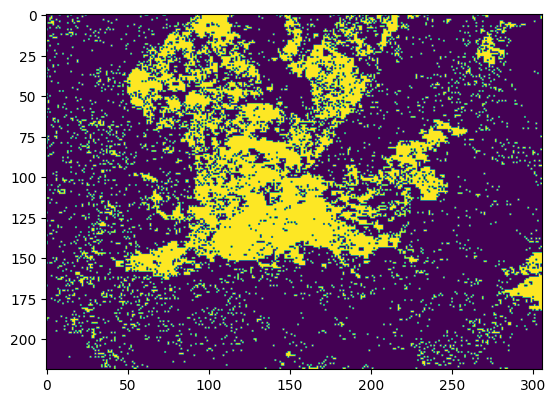

In [66]:
plt.imshow(pred)

In [56]:
pd.DataFrame(pred).to_csv('answer.csv')